In [1]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from notebook_utils import get_distribution_over_vocabulary, get_mlm_results, get_downstream_results

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
FIGURE_DIR = "/home/limisiewicz/my-luster/entangled-in-scripts/output/figures"
TABLE_DIR =  "/home/limisiewicz/my-luster/entangled-in-scripts/output/tables"

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18


## Parameteres

In [6]:
languages = ('ar', 'tr', 'zh','el', 'es', 'en')
alpha = 0.25
tokenization_types = ('multilingual', 'merged', 'nooverlap', 'bpe')
N_vocab = 120000


ft_type = 'PROBE'

In [7]:
in_lang_results = pd.DataFrame(columns=['task', 'metric', 'tokenizer'] + list(languages) + ['multilingual'] )
in_lang_stds = pd.DataFrame(columns=['task', 'metric', 'tokenizer'] + list(languages) + ['multilingual'] )

# Tokenizers and Distributions over Vocabulary

In [8]:
vocab_distributions = {tok_type: get_distribution_over_vocabulary(tok_type, alpha, N_vocab, languages) for 
                      tok_type in tokenization_types}

## Probability Distribution Function
The tokens are sorted by frequency

In [9]:
def boxplot_across_languages(res, metric, languages, task=None):
    if task:
        metric_df = pd.melt(res[(res.metric == metric) & (res.task == task)], id_vars='tokenizer',
                     value_vars=languages, value_name=metric, var_name="language")
    else:
        metric_df = pd.melt(res[res.metric == metric], id_vars='tokenizer',
                     value_vars=languages, value_name=metric, var_name="language")
    sns.boxplot(data=metric_df, x=metric, y='tokenizer')

<Figure size 640x480 with 0 Axes>

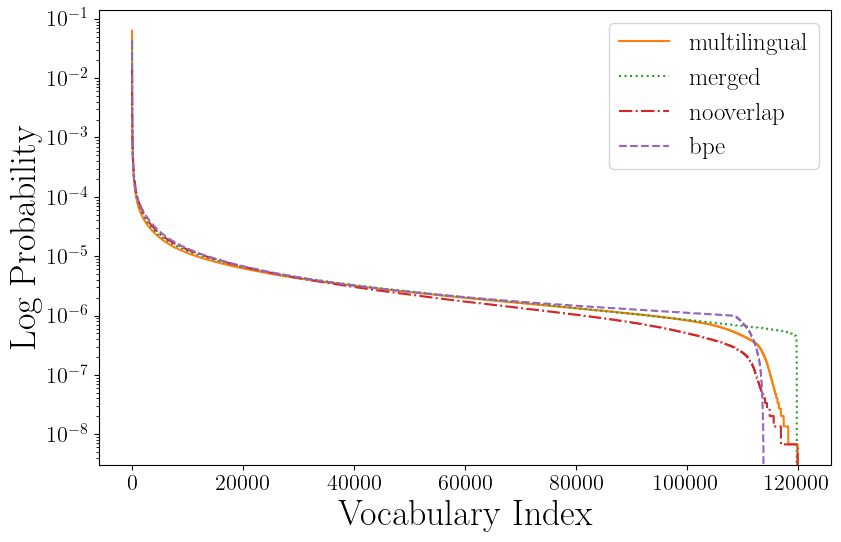

In [10]:
line_styles=['-', ':', '-.', '--']
colors= ["C1", "C2", "C3", "C4"]
plt.figure()
f, ax = plt.subplots(figsize=(9, 6))
for t_idx, tokenization in enumerate(tokenization_types):
    sorted_data = np.sort(vocab_distributions[tokenization]['multilingual'])[::-1]
    ax.plot(sorted_data,c=colors[t_idx],ls=line_styles[t_idx], label=tokenization)
ax.set_yscale('log')
ax.set_ylabel('Log Probability')
ax.set_xlabel('Vocabulary Index')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_log_pdf.pdf"), dpi=300)
plt.show()

## Cumulative Distribution Function

<Figure size 640x480 with 0 Axes>

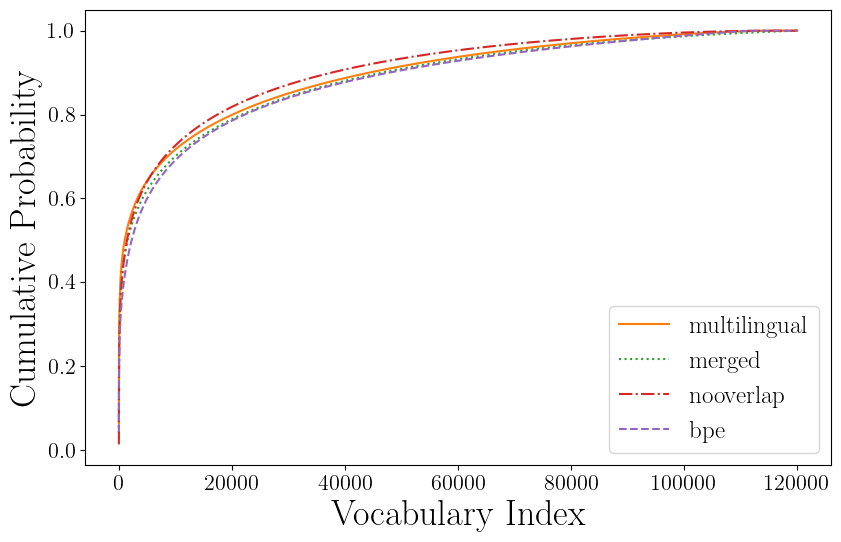

In [36]:
line_styles=['-', ':', '-.', '--']
colors= ["C1", "C2", "C3", "C4"]
plt.figure()
f, ax = plt.subplots(figsize=(9, 6))
for t_idx, tokenization in enumerate(tokenization_types):
    sorted_data = np.sort(vocab_distributions[tokenization]['multilingual'])[::-1]
    cdf = np.cumsum(sorted_data)
    ax.plot(cdf,c=colors[t_idx],ls=line_styles[t_idx], label=tokenization)

ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Vocabulary Index')
ax.legend()


plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_cdf.pdf"), dpi=300)
plt.show()

## Cumulative Distribution Functions (for specific languages)

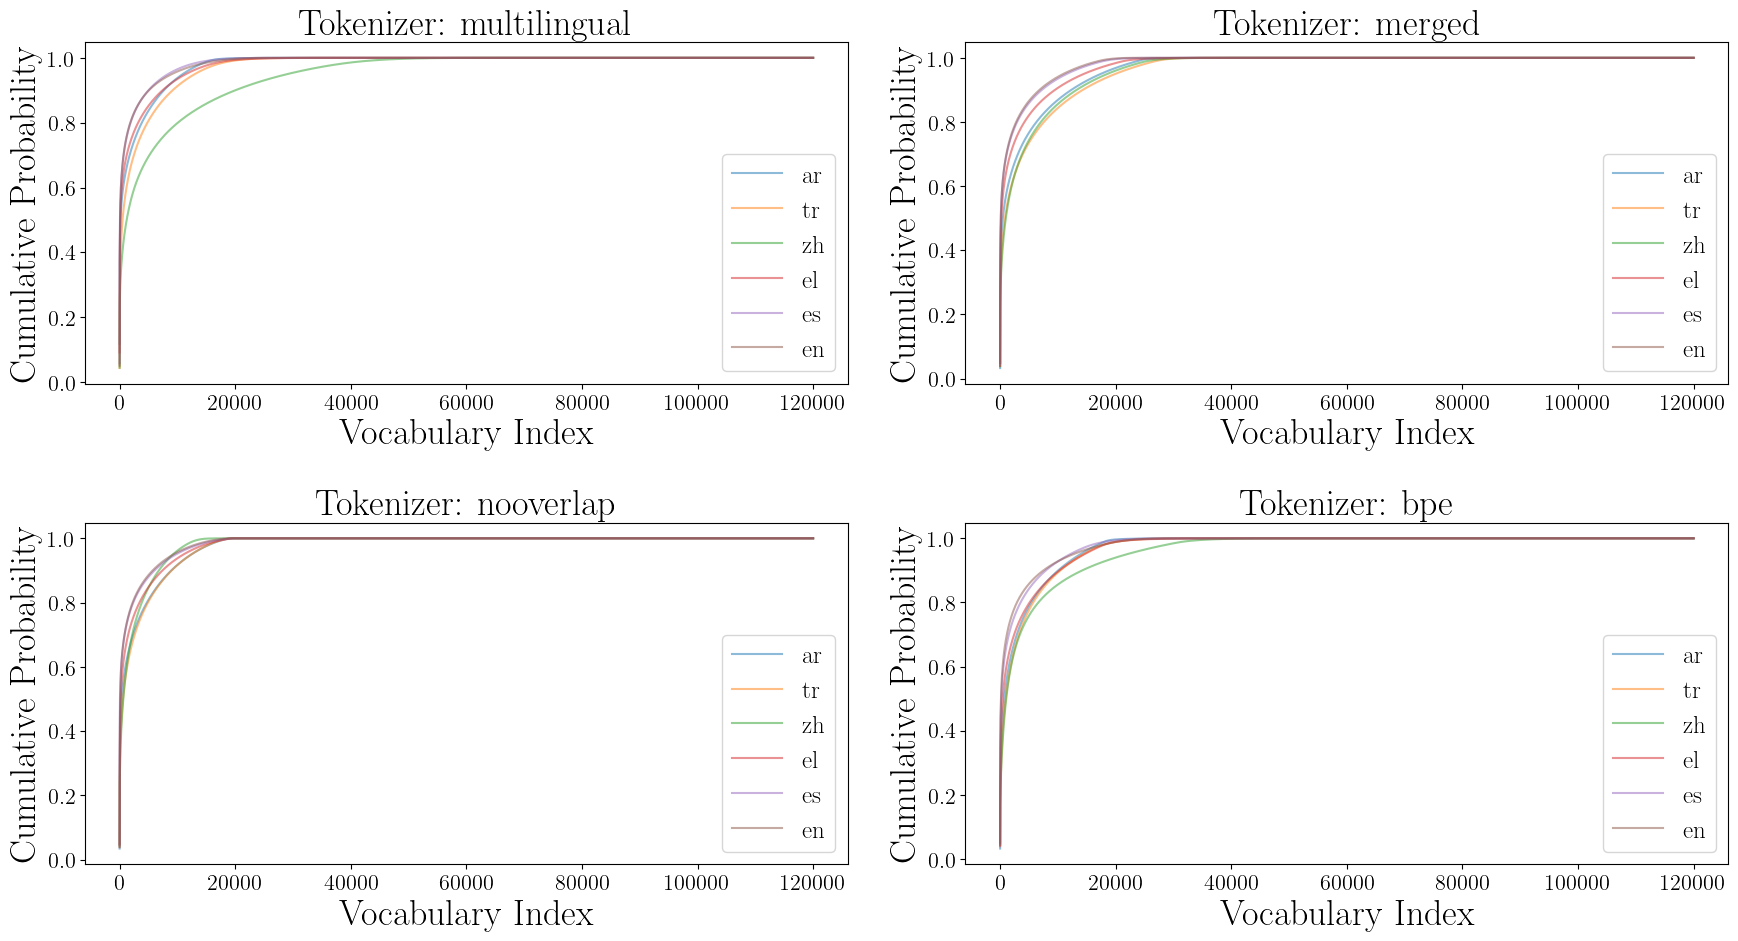

In [12]:
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
axes = axes.ravel()
for t_idx, tokenization in enumerate(tokenization_types):
    ax = axes[t_idx]
    for lang in languages:
        sorted_lang_data = np.sort(vocab_distributions[tokenization][lang])[::-1]
        axes[t_idx].plot(np.cumsum(sorted_lang_data), label=lang, alpha=0.5)
        axes[t_idx].set_ylabel('Cumulative Probability')
        axes[t_idx].set_xlabel('Vocabulary Index')
        axes[t_idx].legend()
    axes[t_idx].set_title(f"Tokenizer: {tokenization}")
    axes[t_idx].legend()

    
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_cdf_each_language.pdf"), dpi=300)
plt.show()

## Average Ranks of Vocabulary Units (Vocab allocation)

In [13]:
def compute_rank_average(probabilites):
    sorted_probabilities = np.sort(probabilites)[::-1]
    r_e = np.sum(sorted_probabilities * np.arange(len(probabilites)))
    return r_e

def compute_rank_std(probabilites):
    sorted_probabilities = np.sort(probabilites)[::-1]
    r_e = np.sum(sorted_probabilities * np.arange(len(probabilites)))
    r_e2 = np.sum(sorted_probabilities * (np.arange(len(probabilites)) ** 2.))
    
    return np.sqrt(r_e2 - (r_e ** 2.))
    

In [14]:
for tokenization in tokenization_types:
    rank_est = {'task': 'allocation', 'metric': 'Avg. Rank', 'tokenizer': tokenization} 
    rank_std = {'task': 'allocation', 'metric': 'Avg. Rank', 'tokenizer': tokenization} 

    for lang, probabilities in vocab_distributions[tokenization].items():
        rank_est[lang] = compute_rank_average(probabilities)
        rank_std[lang] = compute_rank_std(probabilities)

    in_lang_results = in_lang_results.append(rank_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(rank_std, ignore_index=True)

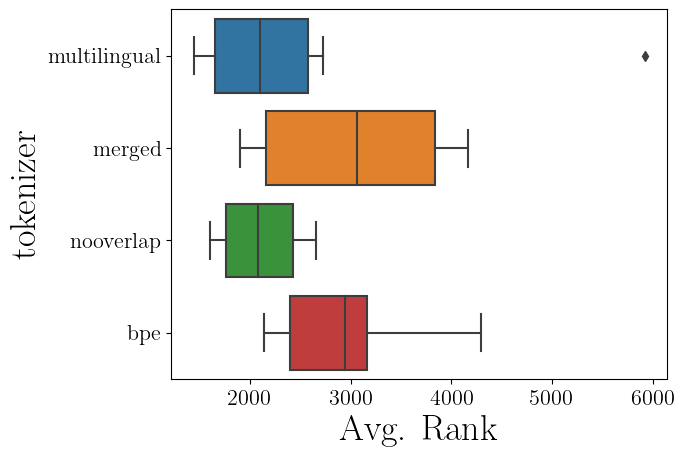

In [15]:
boxplot_across_languages(in_lang_results, 'Avg. Rank', languages)

# Results for LMs

## Original task performance (MRR / BPC)

In [16]:
mlm_results = {tok_type: get_mlm_results(tok_type, alpha, N_vocab, languages) for 
                      tok_type in tokenization_types}

Mean reciprocal rank

In [17]:


for tokenization in tokenization_types:
    mrr_est = {'task': 'LM', 'metric': 'MRR', 'tokenizer': tokenization} 
    mrr_std = {'task': 'LM', 'metric': 'MRR', 'tokenizer': tokenization} 
    
    mrr_est.update(mlm_results[tokenization]['mrr'])
    mrr_est['multilingual'] = np.average(list(mlm_results[tokenization]['mrr'].values()))
    
    for lang in languages:
        mrr_std[lang] = 0.
    mrr_std['multilingual'] = 0.

    in_lang_results = in_lang_results.append(mrr_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(mrr_std, ignore_index=True)

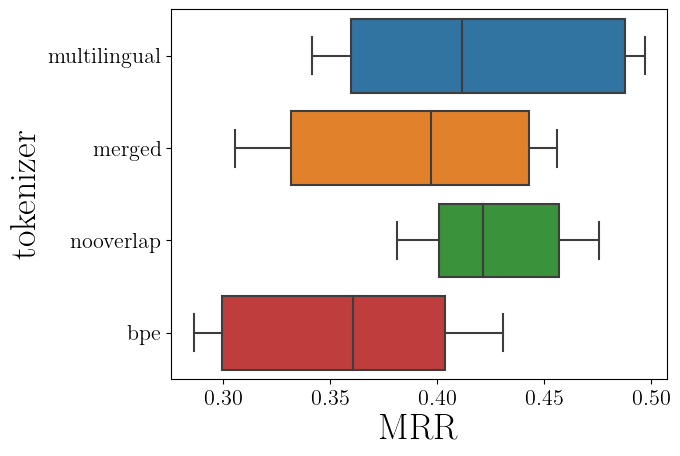

In [18]:
boxplot_across_languages(in_lang_results, 'MRR', languages)

Bits per character

In [19]:
for tokenization in tokenization_types:
    mrr_est = {'task': 'LM', 'metric': 'BPC', 'tokenizer': tokenization} 
    mrr_std = {'task': 'LM', 'metric': 'BPC', 'tokenizer': tokenization} 
    
    mrr_est.update(mlm_results[tokenization]['bpc'])
    mrr_est['multilingual'] = np.average(list(mlm_results[tokenization]['bpc'].values()))
    
    for lang in languages:
        mrr_std[lang] = 0.
    mrr_std['multilingual'] = 0.

    in_lang_results = in_lang_results.append(mrr_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(mrr_std, ignore_index=True)

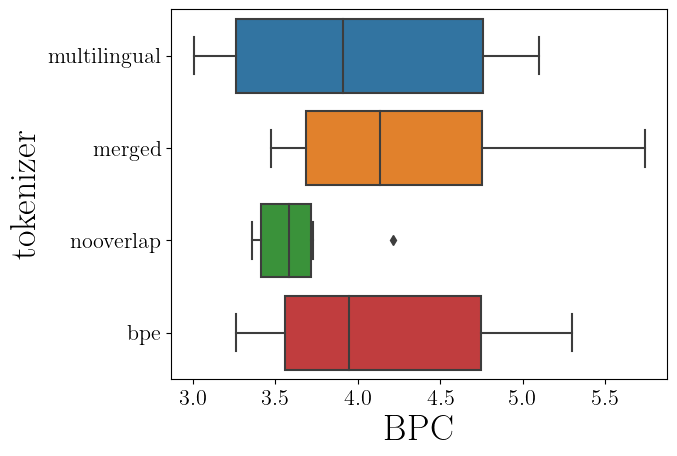

In [20]:
boxplot_across_languages(in_lang_results, 'BPC', languages)

## Down-stream task performance (POS / NER / ...)

POS

In [21]:
pos_results = dict()
pos_stds = dict()

metrics = ('accuracy','f1-macro')
for tok_type in tokenization_types:
    pos_results[tok_type], pos_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'POS', metrics=metrics)
    pos_results[tok_type] = {m : {lang: pos_results[tok_type][m][lang][lang] for lang in languages}
                             for m in metrics}
    pos_stds[tok_type] = {m: {lang: pos_stds[tok_type][m][lang][lang] for lang in languages}
                          for m in metrics}

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/zh/f1-macro_evaluation/zh/f1-macro_all.txt not found.


In [22]:
for tokenization in tokenization_types:
    pos_est = {'task': 'POS', 'metric': 'F1', 'tokenizer': tokenization} 
    pos_std = {'task': 'POS', 'metric': 'F1', 'tokenizer': tokenization} 
    
    pos_est.update(pos_results[tokenization]['f1-macro'])
    pos_est['multilingual'] = np.average(list(pos_results[tokenization]['f1-macro'].values()))
    
    pos_std.update(pos_stds[tokenization]['f1-macro'])
    pos_std['multilingual'] = np.average(list(pos_stds[tokenization]['f1-macro'].values()))
    

    in_lang_results = in_lang_results.append(pos_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(pos_std, ignore_index=True)

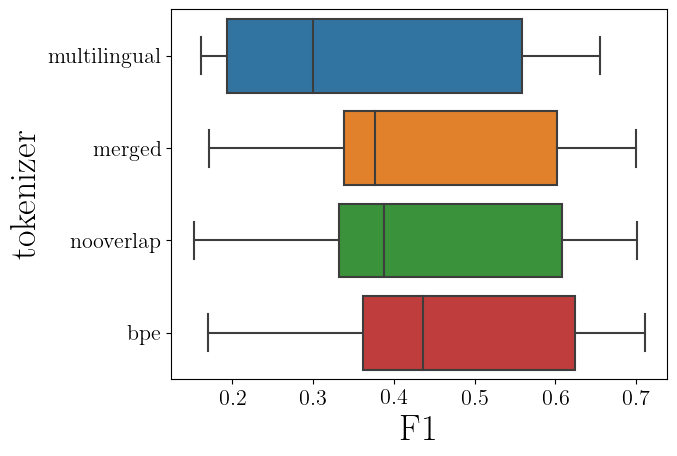

In [23]:
boxplot_across_languages(in_lang_results, 'F1', languages, task='POS')

NER

In [24]:
ner_results = dict()
ner_stds = dict()

metrics = ('f1-seqeval','f1-macro')
for tok_type in tokenization_types:
    ner_results[tok_type], ner_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'NER', metrics=metrics)
    ner_results[tok_type] = {m : {lang: ner_results[tok_type][m][lang][lang] for lang in languages}
                             for m in metrics}
    ner_stds[tok_type] = {m: {lang: ner_stds[tok_type][m][lang][lang] for lang in languages}
                          for m in metrics}

In [25]:
for tokenization in tokenization_types:
    ner_est = {'task': 'NER', 'metric': 'F1', 'tokenizer': tokenization} 
    ner_std = {'task': 'NER', 'metric': 'F1', 'tokenizer': tokenization} 
    
    ner_est.update(ner_results[tokenization]['f1-macro'])
    ner_est['multilingual'] = np.average(list(ner_results[tokenization]['f1-macro'].values()))
    
    ner_std.update(ner_stds[tokenization]['f1-macro'])
    ner_std['multilingual'] = np.average(list(ner_stds[tokenization]['f1-macro'].values()))
    

    in_lang_results = in_lang_results.append(ner_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(ner_std, ignore_index=True)

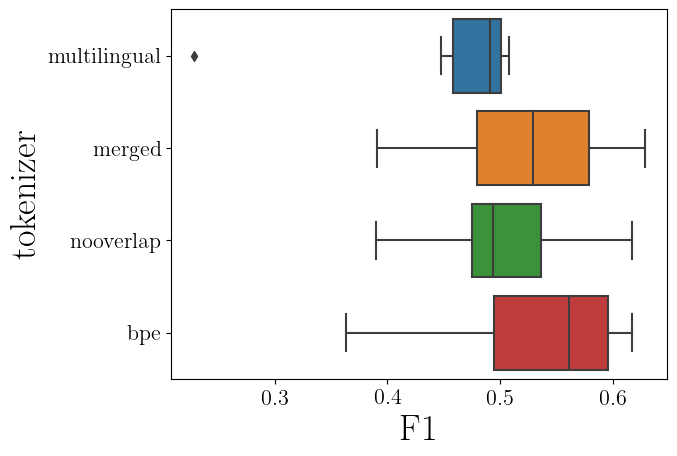

In [26]:
boxplot_across_languages(in_lang_results, 'F1', languages, task='NER')

# Correlation Analysis

In [27]:
in_lang_results

,task,metric,tokenizer,ar,tr,zh,el,es,en,multilingual
0,allocation,Avg. Rank,multilingual,2128.996413,2719.479702,5919.261158,2069.565043,1438.720658,1513.473673,12253.403222
1,allocation,Avg. Rank,merged,3485.472526,4167.260212,3960.897091,2638.804431,1999.259312,1898.366950,13187.126035
2,allocation,Avg. Rank,nooverlap,2537.300747,2652.708950,2089.915780,2065.312074,1661.233287,1596.648191,10976.397411
3,allocation,Avg. Rank,bpe,2971.967713,3226.334486,4293.898619,2907.373062,2219.935584,2142.562768,13644.811079
4,LM,MRR,multilingual,0.359685,0.360099,0.341552,0.463133,0.496743,0.495787,0.419500
5,LM,MRR,merged,0.315037,0.305593,0.382171,0.412005,0.453381,0.455806,0.387332
6,LM,MRR,nooverlap,0.381145,0.396091,0.414300,0.428457,0.475431,0.466204,0.426938
7,LM,MRR,bpe,0.287334,0.335945,0.286264,0.385598,0.430695,0.409817,0.355942
8,LM,BPC,multilingual,5.097600,4.461929,4.854915,3.361697,3.005752,3.232518,4.002402
9,LM,BPC,merged,5.736469,4.930816,4.047776,4.219898,3.475078,3.563784,4.328970


In [28]:
in_lang_stds

,task,metric,tokenizer,ar,tr,zh,el,es,en,multilingual
0,allocation,Avg. Rank,multilingual,3698.810585,4458.063481,9757.556349,4072.095304,3084.238901,3338.665516,22278.476212
1,allocation,Avg. Rank,merged,5749.524183,6553.719510,6129.697408,4903.292342,3946.242865,3727.780663,23387.856965
2,allocation,Avg. Rank,nooverlap,4108.877280,4076.723393,3049.616182,3728.597014,3364.785016,3211.362064,19840.187884
3,allocation,Avg. Rank,bpe,4526.087423,4805.028906,7222.667853,4905.489042,4134.843000,4353.256519,23430.039921
4,LM,MRR,multilingual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,LM,MRR,merged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,LM,MRR,nooverlap,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,LM,MRR,bpe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,LM,BPC,multilingual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,LM,BPC,merged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Pairwaise factor analysis

In [29]:
in_lang_ca = pd.melt(in_lang_results, id_vars=['task', 'metric', 'tokenizer'],
                     value_vars=languages, var_name='language').\
                    pivot_table(columns=['task', 'metric'], values='value', index=['language', 'tokenizer']).\
                    reset_index()

in_lang_ca.columns = ["_".join(pair) for pair in in_lang_ca.columns]

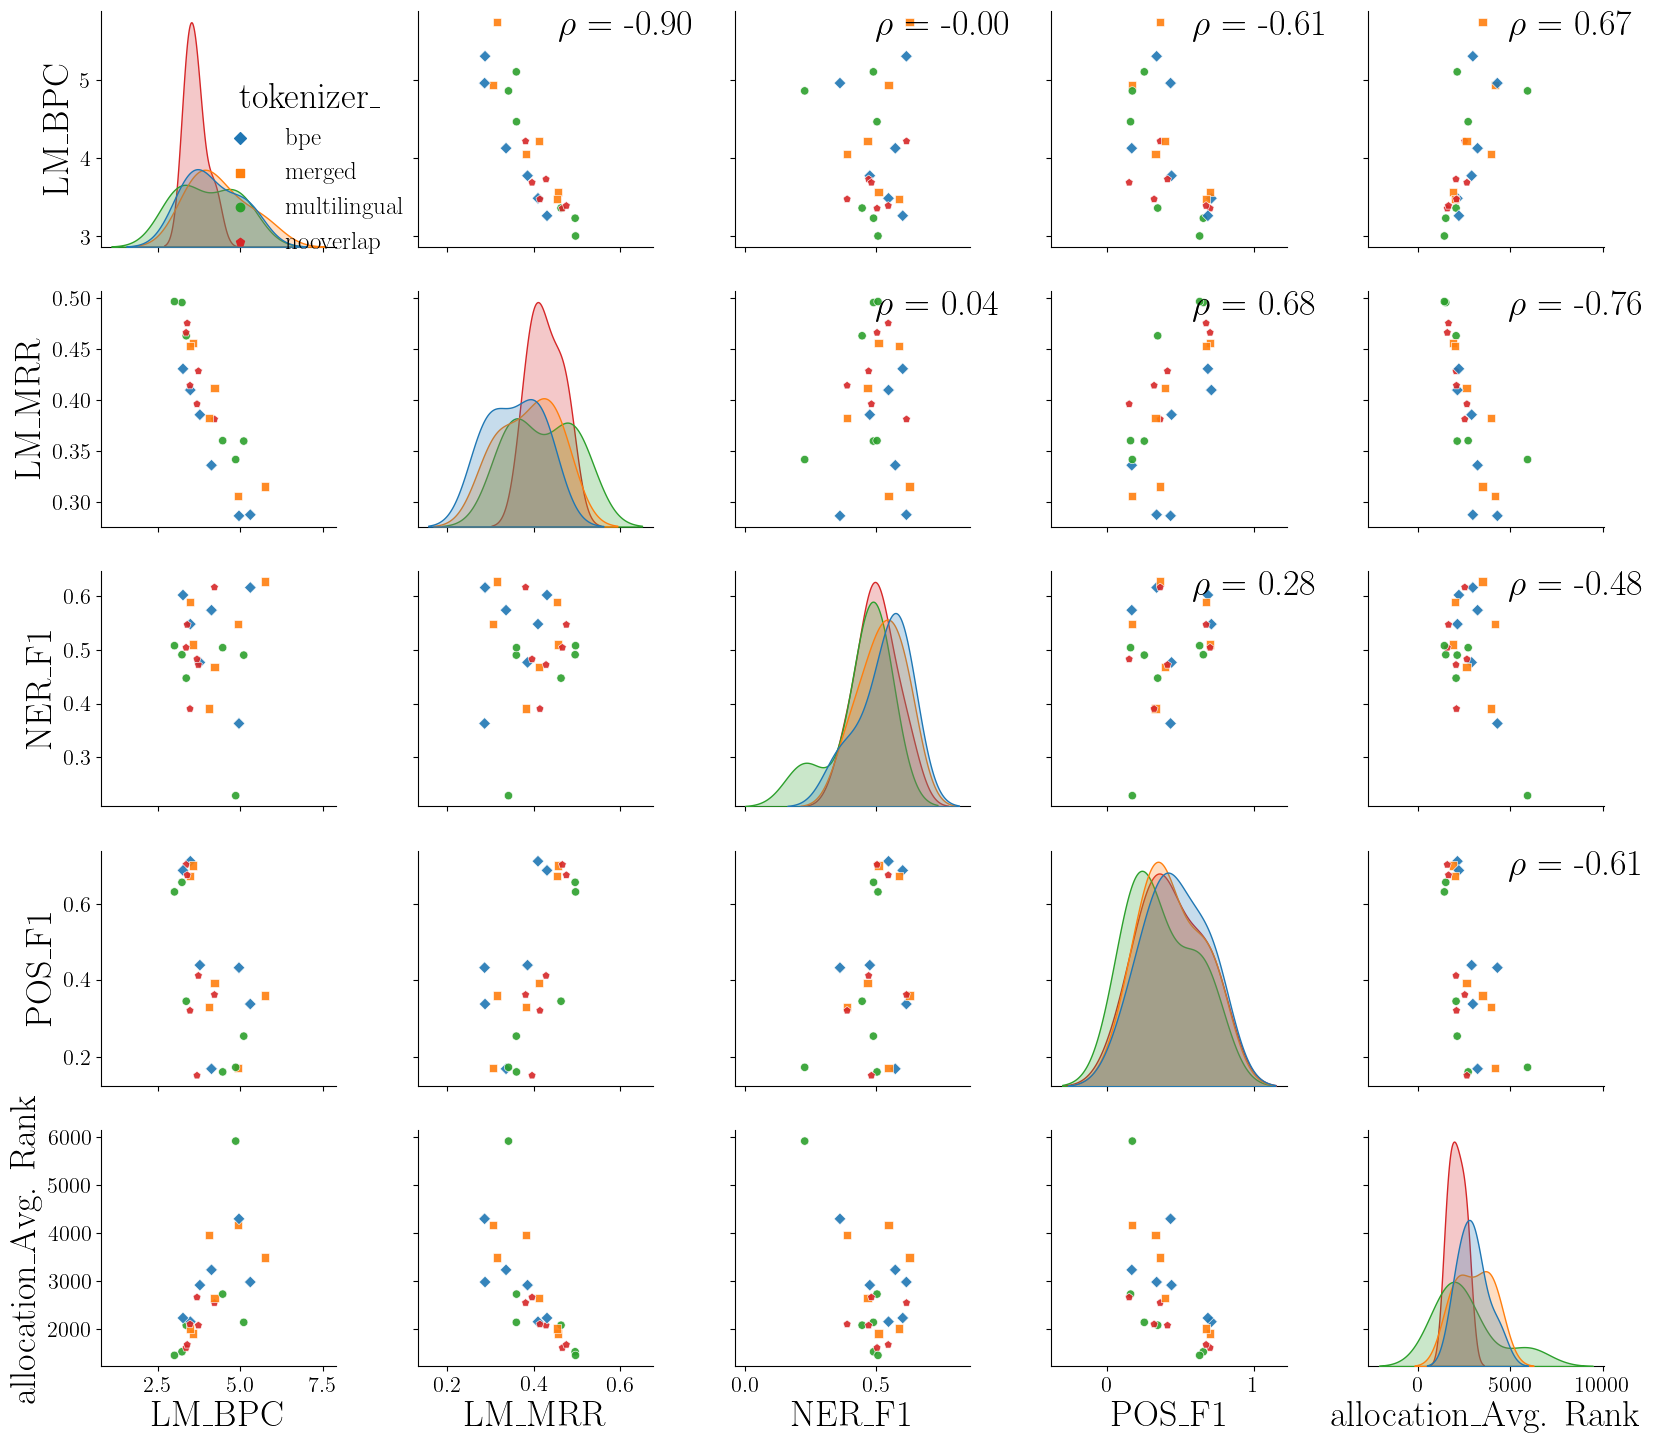

In [35]:
spearman_r = in_lang_ca.corr(method='pearson').to_numpy()
spearman_p = in_lang_ca.corr(method=lambda x, y: pearsonr(x, y)[1]).to_numpy()

#plt.figure(figsize=(3.5,3.5))
plot1 = sns.pairplot(in_lang_ca, hue="tokenizer_",
                     markers=['D','s', 'o', 'p', 'X'],
                     plot_kws={'alpha': 0.9},
                    size=3)

plot1._legend.set_bbox_to_anchor((.25, 0.85))
# plt.legend(loc='center right', title='Type')
plot1.map
axes = plot1.axes
for i in range(4):
    for j in range(i+1,5):
        ax = axes[i][j]
        r = spearman_r[i,j]
        p = spearman_p[i,j]
        ax.annotate(r"$\rho$ = {:.2f}".format(r), xy=(.6, .9), xycoords=ax.transAxes)
#         ax.annotate(r"$p$ = {:.4f}".format(p), xy=(.7, .8), xycoords=ax.transAxes)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "pair_analysis.pdf"), dpi=300)


In [32]:
spearman_r

array([[ 1.        , -0.89623337, -0.00421985, -0.61094562,  0.67458226],
       [-0.89623337,  1.        ,  0.03847451,  0.68283459, -0.76356549],
       [-0.00421985,  0.03847451,  1.        ,  0.28156671, -0.47939891],
       [-0.61094562,  0.68283459,  0.28156671,  1.        , -0.61450858],
       [ 0.67458226, -0.76356549, -0.47939891, -0.61450858,  1.        ]])

In [33]:
spearman_p

array([[1.00000000e+00, 3.18042029e-09, 9.84386884e-01, 1.51779202e-03,
        2.99894227e-04],
       [3.18042029e-09, 1.00000000e+00, 8.58338656e-01, 2.36185790e-04,
        1.41878472e-05],
       [9.84386884e-01, 8.58338656e-01, 1.00000000e+00, 1.82561928e-01,
        1.77692052e-02],
       [1.51779202e-03, 2.36185790e-04, 1.82561928e-01, 1.00000000e+00,
        1.39870056e-03],
       [2.99894227e-04, 1.41878472e-05, 1.77692052e-02, 1.39870056e-03,
        1.00000000e+00]])